# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
        
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    output_layer = layers.concatenate([upsampled_layer, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
#    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    x1 = encoder_block(inputs, 32, 2)
    x2 = encoder_block(x1, 64, 2)
    x3 = encoder_block(x2, 128, 2)
    x4 = encoder_block(x3, 256, 2)
    x5 = encoder_block(x4, 512, 2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    onebyone_conv_layer = conv2d_batchnorm(x5,1024,kernel_size=1,strides=1)
    #onebyone_conv_layer = conv2d_batchnorm(x4,512,kernel_size=1,strides=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    x5_p = decoder_block(onebyone_conv_layer, x4, 512)
    x4_p = decoder_block(x5_p, x3, 256)
    #x4_p = decoder_block(onebyone_conv_layer, x3, 256)
    x3_p = decoder_block(x4_p, x2, 128)
    x2_p = decoder_block(x3_p, x1, 64)
    x1_p = decoder_block(x2_p, inputs, 32)
    
    #======Network Shape========
    print(inputs)
    print(x1)
    print(x2)
    print(x3)
    print(x4)
    print(x5)
    print(onebyone_conv_layer)
    print(x5_p)
    print(x4_p)
    print(x3_p)
    print(x2_p)
    print(x1_p)
    #======Network Shape========
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x1_p)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 256
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

Tensor("input_1:0", shape=(?, 256, 256, 3), dtype=float32)
Tensor("batch_normalization/batchnorm/add_1:0", shape=(?, 128, 128, 32), dtype=float32)
Tensor("batch_normalization_2/batchnorm/add_1:0", shape=(?, 64, 64, 64), dtype=float32)
Tensor("batch_normalization_3/batchnorm/add_1:0", shape=(?, 32, 32, 128), dtype=float32)
Tensor("batch_normalization_4/batchnorm/add_1:0", shape=(?, 16, 16, 256), dtype=float32)
Tensor("batch_normalization_5/batchnorm/add_1:0", shape=(?, 8, 8, 512), dtype=float32)
Tensor("batch_normalization_6/batchnorm/add_1:0", shape=(?, 8, 8, 1024), dtype=float32)
Tensor("batch_normalization_7/batchnorm/add_1:0", shape=(?, 16, 16, 512), dtype=float32)
Tensor("batch_normalization_8/batchnorm/add_1:0", shape=(?, 32, 32, 256), dtype=float32)
Tensor("batch_normalization_9/batchnorm/add_1:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("batch_normalization_10/batchnorm/add_1:0", shape=(?, 128, 128, 64), dtype=float32)
Tensor("batch_normalization_11/batchnorm/add_1:0", sha

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.0005 # 0.0001 - slow
batch_size = 64 #512/384 => Exhaust resources
num_epochs = 100
num_img_train = 3734
num_img_validation = 1184
steps_per_epoch = int(num_img_train / batch_size) +1
validation_steps = int(num_img_validation / batch_size) +1
workers = 4
print('Steps per epoch: ' + str(steps_per_epoch))
print('Validation steps: ' + str(validation_steps))

Steps per epoch: 59
Validation steps: 19


Epoch 1/100
58/59 [============================>.] - ETA: 1s - loss: 0.6909

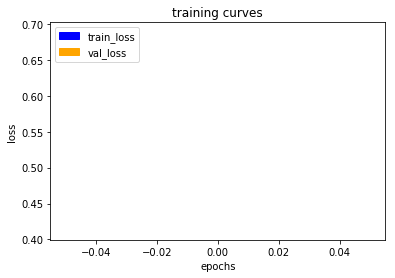

59/59 [==============================] - 113s - loss: 0.6849 - val_loss: 0.4132
Epoch 2/100
58/59 [============================>.] - ETA: 1s - loss: 0.1849

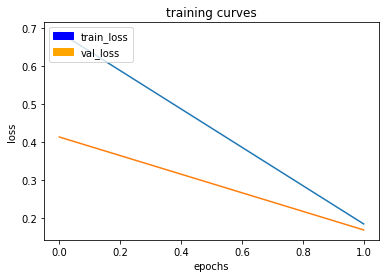

59/59 [==============================] - 112s - loss: 0.1836 - val_loss: 0.1687
Epoch 3/100
58/59 [============================>.] - ETA: 1s - loss: 0.0817

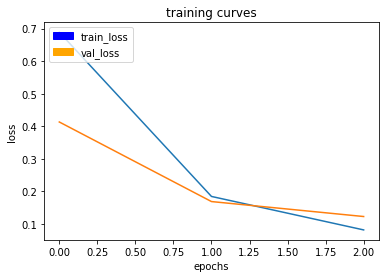

59/59 [==============================] - 112s - loss: 0.0814 - val_loss: 0.1227
Epoch 4/100
58/59 [============================>.] - ETA: 1s - loss: 0.0545

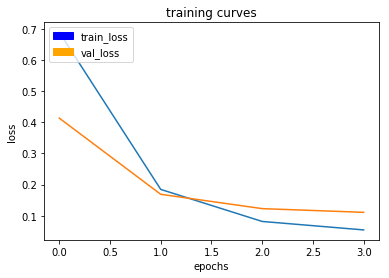

59/59 [==============================] - 112s - loss: 0.0544 - val_loss: 0.1108
Epoch 5/100
58/59 [============================>.] - ETA: 1s - loss: 0.0469

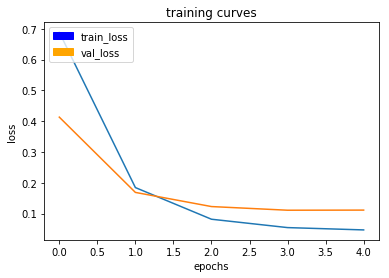

59/59 [==============================] - 113s - loss: 0.0468 - val_loss: 0.1112
Epoch 6/100
58/59 [============================>.] - ETA: 1s - loss: 0.0371

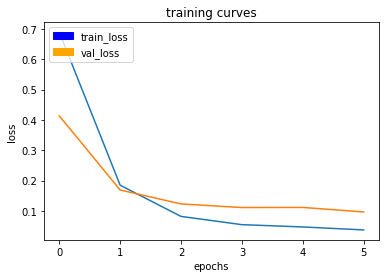

59/59 [==============================] - 113s - loss: 0.0371 - val_loss: 0.0963
Epoch 7/100
58/59 [============================>.] - ETA: 1s - loss: 0.0322

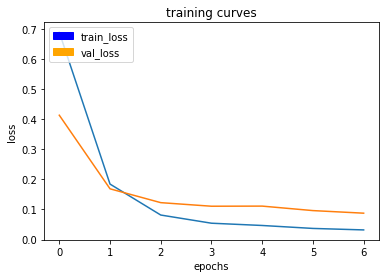

59/59 [==============================] - 113s - loss: 0.0322 - val_loss: 0.0878
Epoch 8/100
58/59 [============================>.] - ETA: 1s - loss: 0.0288

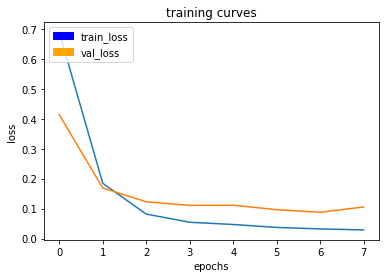

59/59 [==============================] - 113s - loss: 0.0289 - val_loss: 0.1054
Epoch 9/100
58/59 [============================>.] - ETA: 1s - loss: 0.1705

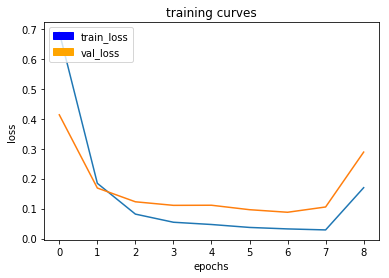

59/59 [==============================] - 113s - loss: 0.1686 - val_loss: 0.2886
Epoch 10/100
58/59 [============================>.] - ETA: 1s - loss: 0.0595

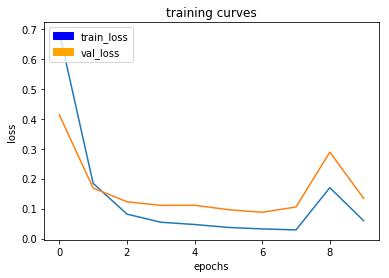

59/59 [==============================] - 113s - loss: 0.0594 - val_loss: 0.1338
Epoch 11/100
58/59 [============================>.] - ETA: 1s - loss: 0.0510

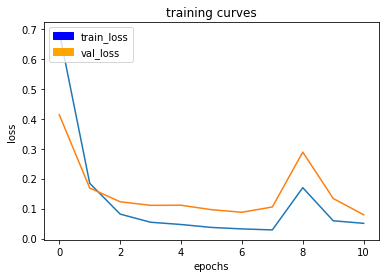

59/59 [==============================] - 113s - loss: 0.0508 - val_loss: 0.0793
Epoch 12/100
58/59 [============================>.] - ETA: 1s - loss: 0.0457

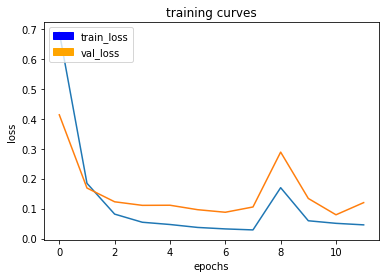

59/59 [==============================] - 113s - loss: 0.0457 - val_loss: 0.1199
Epoch 13/100
58/59 [============================>.] - ETA: 1s - loss: 0.0418

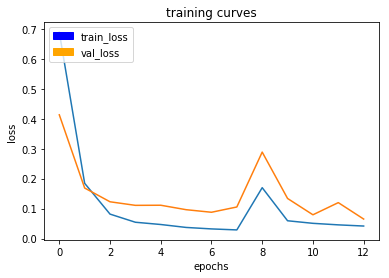

59/59 [==============================] - 113s - loss: 0.0417 - val_loss: 0.0651
Epoch 14/100
58/59 [============================>.] - ETA: 1s - loss: 0.0392

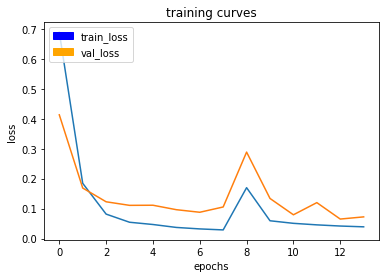

59/59 [==============================] - 113s - loss: 0.0391 - val_loss: 0.0723
Epoch 15/100
58/59 [============================>.] - ETA: 1s - loss: 0.0362

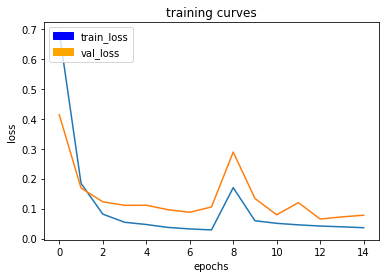

59/59 [==============================] - 113s - loss: 0.0362 - val_loss: 0.0779
Epoch 16/100
58/59 [============================>.] - ETA: 1s - loss: 0.0352

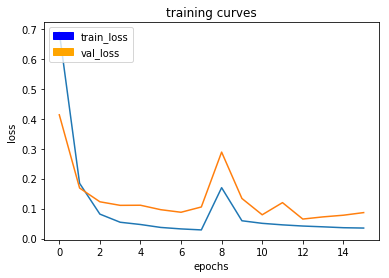

59/59 [==============================] - 113s - loss: 0.0353 - val_loss: 0.0866
Epoch 17/100
58/59 [============================>.] - ETA: 1s - loss: 0.0336

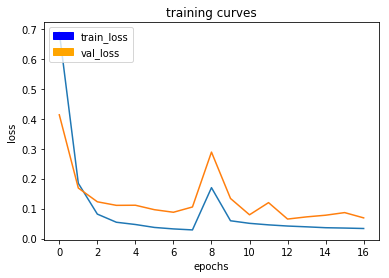

59/59 [==============================] - 112s - loss: 0.0335 - val_loss: 0.0690
Epoch 18/100
58/59 [============================>.] - ETA: 1s - loss: 0.0320

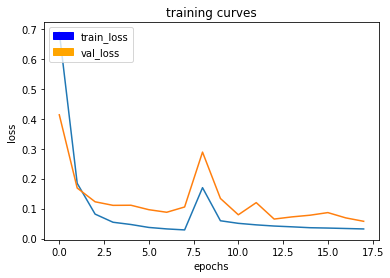

59/59 [==============================] - 113s - loss: 0.0320 - val_loss: 0.0576
Epoch 19/100
58/59 [============================>.] - ETA: 1s - loss: 0.0305

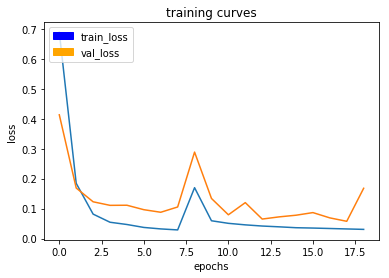

59/59 [==============================] - 113s - loss: 0.0306 - val_loss: 0.1678
Epoch 20/100
58/59 [============================>.] - ETA: 1s - loss: 0.0320

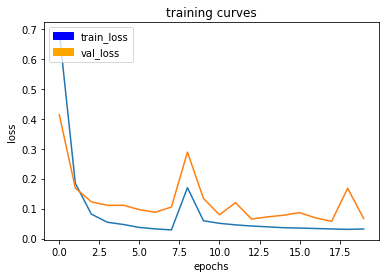

59/59 [==============================] - 113s - loss: 0.0320 - val_loss: 0.0670
Epoch 21/100
58/59 [============================>.] - ETA: 1s - loss: 0.0286

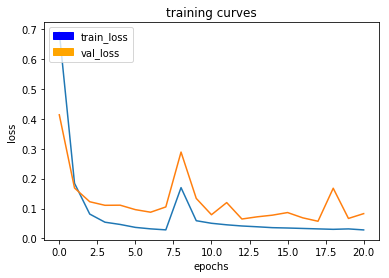

59/59 [==============================] - 113s - loss: 0.0286 - val_loss: 0.0830
Epoch 22/100
58/59 [============================>.] - ETA: 1s - loss: 0.0278

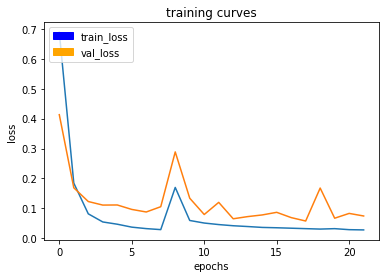

59/59 [==============================] - 113s - loss: 0.0278 - val_loss: 0.0744
Epoch 23/100
58/59 [============================>.] - ETA: 1s - loss: 0.0272

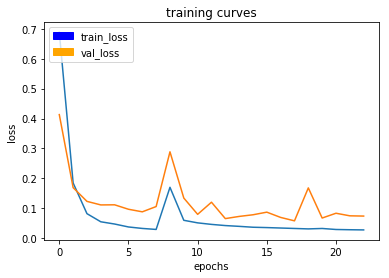

59/59 [==============================] - 113s - loss: 0.0272 - val_loss: 0.0735
Epoch 24/100
58/59 [============================>.] - ETA: 1s - loss: 0.0262

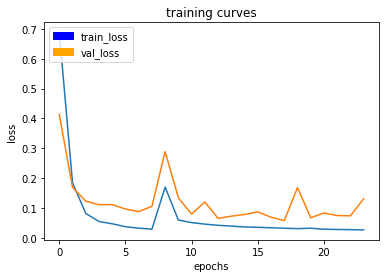

59/59 [==============================] - 113s - loss: 0.0263 - val_loss: 0.1306
Epoch 25/100
58/59 [============================>.] - ETA: 1s - loss: 0.0258

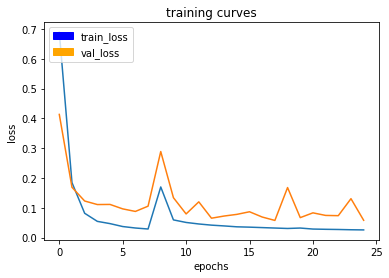

59/59 [==============================] - 112s - loss: 0.0257 - val_loss: 0.0580
Epoch 26/100
58/59 [============================>.] - ETA: 1s - loss: 0.0248

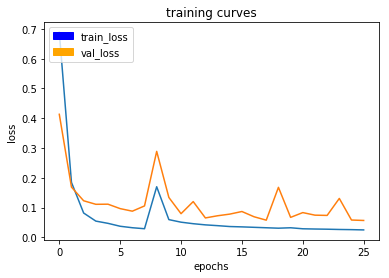

59/59 [==============================] - 113s - loss: 0.0248 - val_loss: 0.0566
Epoch 27/100
58/59 [============================>.] - ETA: 1s - loss: 0.0244

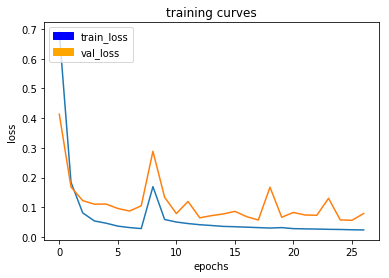

59/59 [==============================] - 113s - loss: 0.0244 - val_loss: 0.0794
Epoch 28/100
58/59 [============================>.] - ETA: 1s - loss: 0.0240

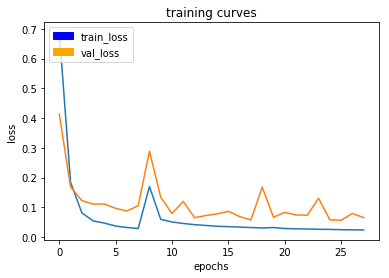

59/59 [==============================] - 112s - loss: 0.0242 - val_loss: 0.0655
Epoch 29/100
58/59 [============================>.] - ETA: 1s - loss: 0.0234

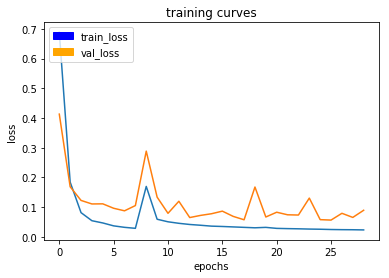

59/59 [==============================] - 112s - loss: 0.0235 - val_loss: 0.0896
Epoch 30/100
58/59 [============================>.] - ETA: 1s - loss: 0.0233

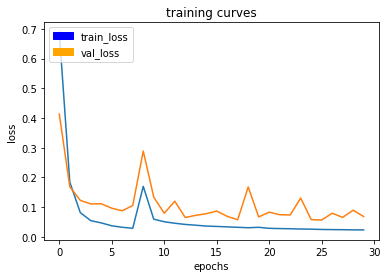

59/59 [==============================] - 113s - loss: 0.0233 - val_loss: 0.0684
Epoch 31/100
58/59 [============================>.] - ETA: 1s - loss: 0.0225

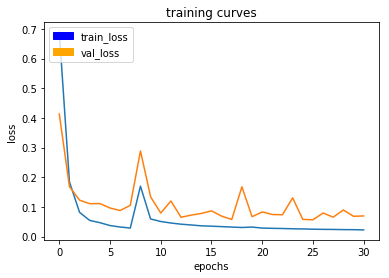

59/59 [==============================] - 113s - loss: 0.0225 - val_loss: 0.0695
Epoch 32/100
58/59 [============================>.] - ETA: 1s - loss: 0.0221

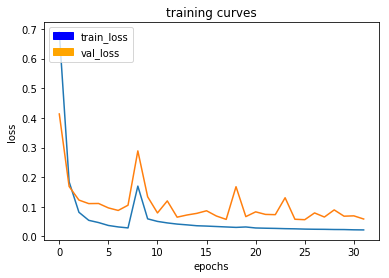

59/59 [==============================] - 113s - loss: 0.0221 - val_loss: 0.0589
Epoch 33/100
58/59 [============================>.] - ETA: 1s - loss: 0.0222

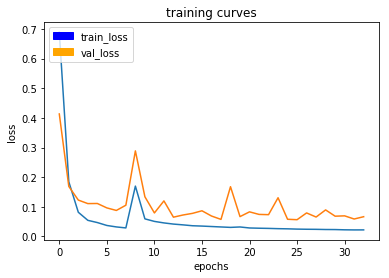

59/59 [==============================] - 113s - loss: 0.0222 - val_loss: 0.0666
Epoch 34/100
58/59 [============================>.] - ETA: 1s - loss: 0.0215

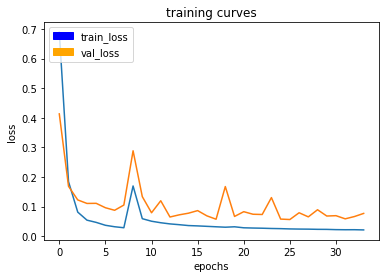

59/59 [==============================] - 113s - loss: 0.0215 - val_loss: 0.0772
Epoch 35/100
58/59 [============================>.] - ETA: 1s - loss: 0.0213

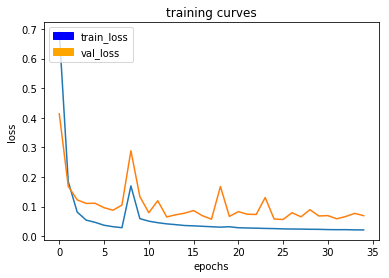

59/59 [==============================] - 113s - loss: 0.0213 - val_loss: 0.0694
Epoch 36/100
58/59 [============================>.] - ETA: 1s - loss: 0.0209

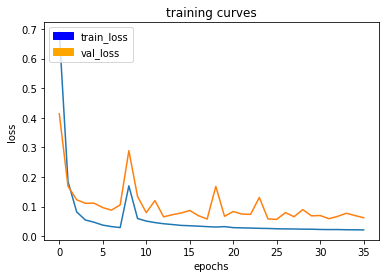

59/59 [==============================] - 113s - loss: 0.0209 - val_loss: 0.0621
Epoch 37/100
58/59 [============================>.] - ETA: 1s - loss: 0.0207

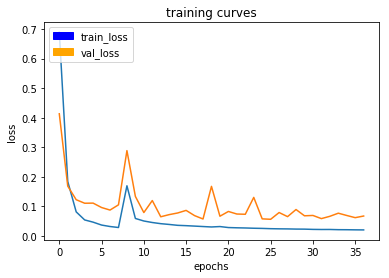

59/59 [==============================] - 113s - loss: 0.0206 - val_loss: 0.0676
Epoch 38/100
58/59 [============================>.] - ETA: 1s - loss: 0.0203

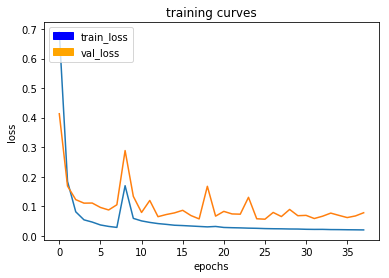

59/59 [==============================] - 114s - loss: 0.0203 - val_loss: 0.0784
Epoch 39/100
58/59 [============================>.] - ETA: 1s - loss: 0.0201

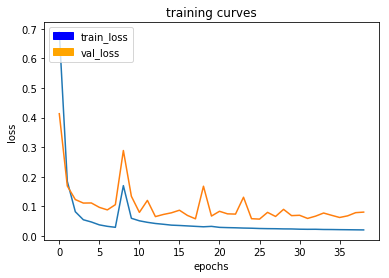

59/59 [==============================] - 113s - loss: 0.0201 - val_loss: 0.0803
Epoch 40/100
58/59 [============================>.] - ETA: 1s - loss: 0.0201

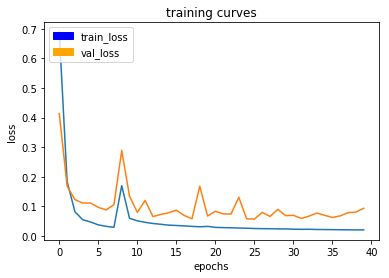

59/59 [==============================] - 113s - loss: 0.0201 - val_loss: 0.0932
Epoch 41/100
58/59 [============================>.] - ETA: 1s - loss: 0.0198

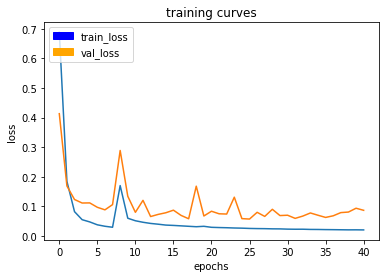

59/59 [==============================] - 113s - loss: 0.0198 - val_loss: 0.0862
Epoch 42/100
58/59 [============================>.] - ETA: 1s - loss: 0.0194

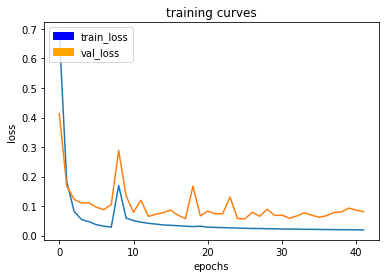

59/59 [==============================] - 113s - loss: 0.0194 - val_loss: 0.0813
Epoch 43/100
58/59 [============================>.] - ETA: 1s - loss: 0.0188

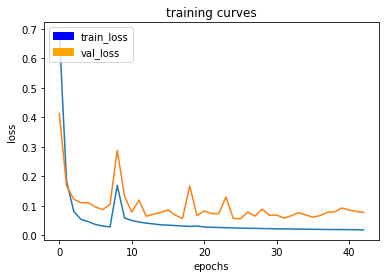

59/59 [==============================] - 113s - loss: 0.0188 - val_loss: 0.0779
Epoch 44/100
58/59 [============================>.] - ETA: 1s - loss: 0.0192

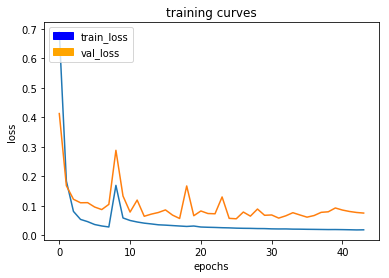

59/59 [==============================] - 112s - loss: 0.0192 - val_loss: 0.0759
Epoch 45/100
58/59 [============================>.] - ETA: 1s - loss: 0.0190

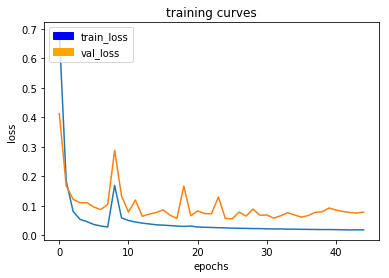

59/59 [==============================] - 112s - loss: 0.0190 - val_loss: 0.0793
Epoch 46/100
58/59 [============================>.] - ETA: 1s - loss: 0.0187

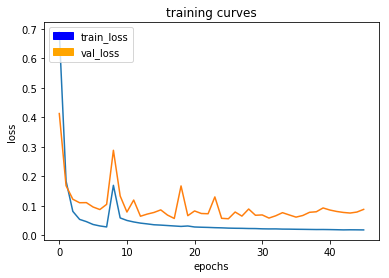

59/59 [==============================] - 113s - loss: 0.0187 - val_loss: 0.0883
Epoch 47/100
58/59 [============================>.] - ETA: 1s - loss: 0.0418

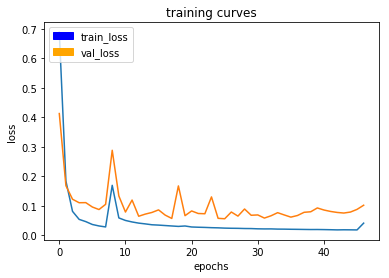

59/59 [==============================] - 113s - loss: 0.0415 - val_loss: 0.1024
Epoch 48/100
58/59 [============================>.] - ETA: 1s - loss: 0.0242

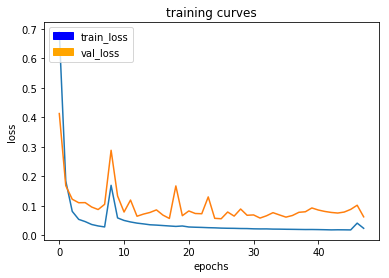

59/59 [==============================] - 112s - loss: 0.0242 - val_loss: 0.0631
Epoch 49/100
58/59 [============================>.] - ETA: 1s - loss: 0.0226

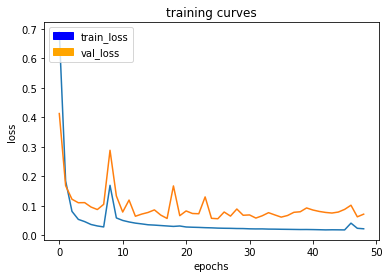

59/59 [==============================] - 113s - loss: 0.0225 - val_loss: 0.0721
Epoch 50/100
58/59 [============================>.] - ETA: 1s - loss: 0.0209

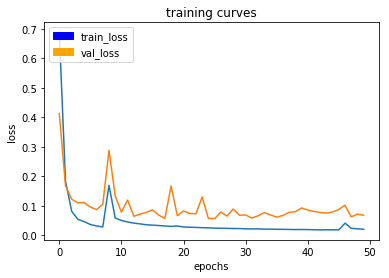

59/59 [==============================] - 113s - loss: 0.0209 - val_loss: 0.0687
Epoch 51/100
58/59 [============================>.] - ETA: 1s - loss: 0.0200

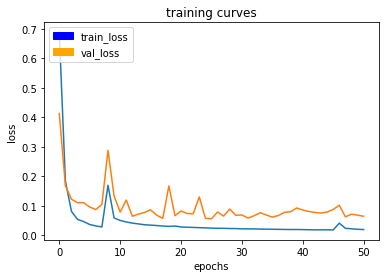

59/59 [==============================] - 112s - loss: 0.0200 - val_loss: 0.0650
Epoch 52/100
58/59 [============================>.] - ETA: 1s - loss: 0.0195

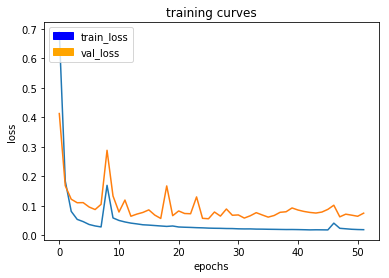

59/59 [==============================] - 113s - loss: 0.0195 - val_loss: 0.0755
Epoch 53/100
58/59 [============================>.] - ETA: 1s - loss: 0.0190

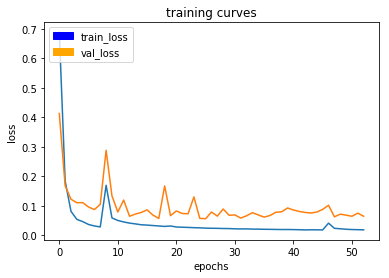

59/59 [==============================] - 113s - loss: 0.0190 - val_loss: 0.0650
Epoch 54/100
58/59 [============================>.] - ETA: 1s - loss: 0.0184

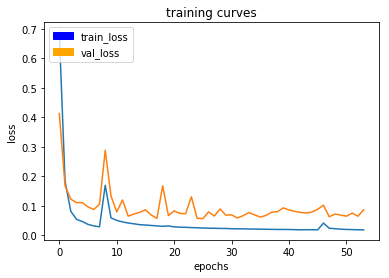

59/59 [==============================] - 112s - loss: 0.0184 - val_loss: 0.0866
Epoch 55/100
58/59 [============================>.] - ETA: 1s - loss: 0.0183

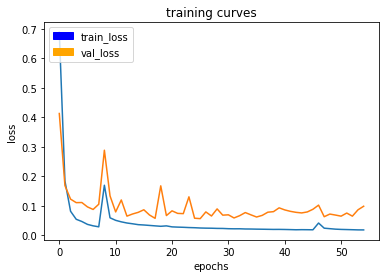

59/59 [==============================] - 113s - loss: 0.0183 - val_loss: 0.0986
Epoch 56/100
58/59 [============================>.] - ETA: 1s - loss: 0.0181

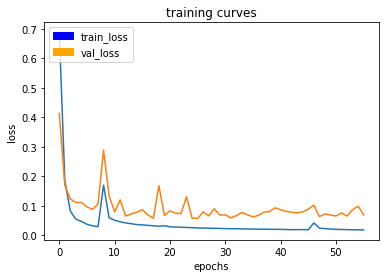

59/59 [==============================] - 112s - loss: 0.0181 - val_loss: 0.0691
Epoch 57/100
58/59 [============================>.] - ETA: 1s - loss: 0.0176

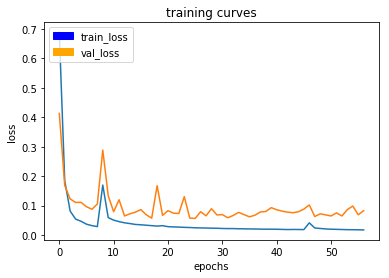

59/59 [==============================] - 113s - loss: 0.0176 - val_loss: 0.0830
Epoch 58/100
58/59 [============================>.] - ETA: 1s - loss: 0.0175

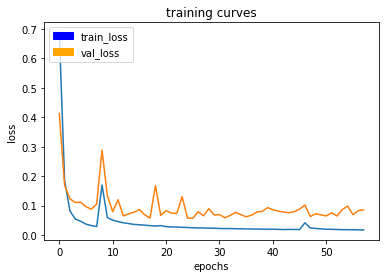

59/59 [==============================] - 113s - loss: 0.0175 - val_loss: 0.0856
Epoch 59/100
58/59 [============================>.] - ETA: 1s - loss: 0.0174

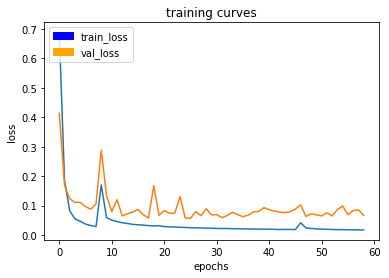

59/59 [==============================] - 112s - loss: 0.0175 - val_loss: 0.0668
Epoch 60/100
58/59 [============================>.] - ETA: 1s - loss: 0.0170

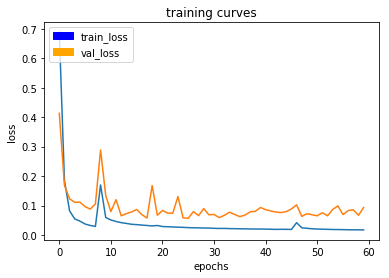

59/59 [==============================] - 113s - loss: 0.0170 - val_loss: 0.0932
Epoch 61/100
58/59 [============================>.] - ETA: 1s - loss: 0.0170

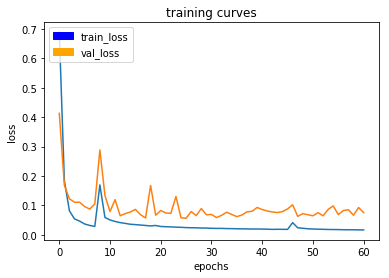

59/59 [==============================] - 113s - loss: 0.0169 - val_loss: 0.0756
Epoch 62/100
58/59 [============================>.] - ETA: 1s - loss: 0.0168

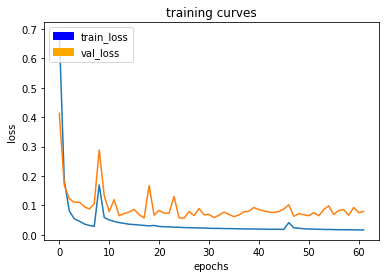

59/59 [==============================] - 113s - loss: 0.0169 - val_loss: 0.0799
Epoch 63/100
58/59 [============================>.] - ETA: 1s - loss: 0.0165

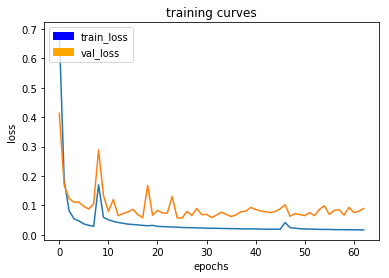

59/59 [==============================] - 113s - loss: 0.0166 - val_loss: 0.0894
Epoch 64/100
58/59 [============================>.] - ETA: 1s - loss: 0.0163

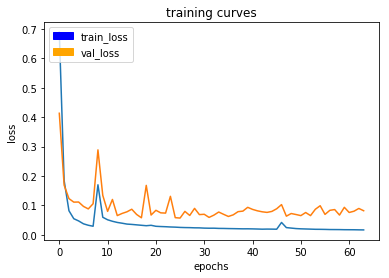

59/59 [==============================] - 112s - loss: 0.0163 - val_loss: 0.0815
Epoch 65/100
58/59 [============================>.] - ETA: 1s - loss: 0.0164

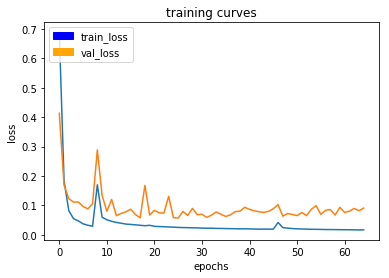

59/59 [==============================] - 113s - loss: 0.0164 - val_loss: 0.0906
Epoch 66/100
58/59 [============================>.] - ETA: 1s - loss: 0.0162

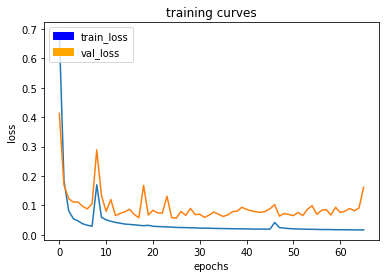

59/59 [==============================] - 113s - loss: 0.0163 - val_loss: 0.1612
Epoch 67/100
58/59 [============================>.] - ETA: 1s - loss: 0.0160

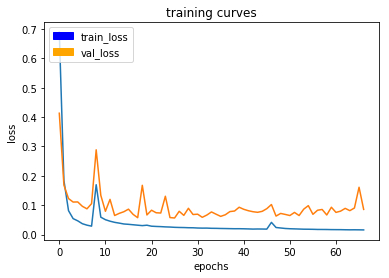

59/59 [==============================] - 113s - loss: 0.0160 - val_loss: 0.0858
Epoch 68/100
58/59 [============================>.] - ETA: 1s - loss: 0.0158

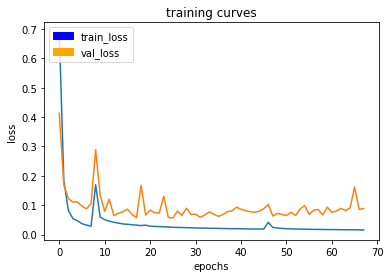

59/59 [==============================] - 113s - loss: 0.0158 - val_loss: 0.0885
Epoch 69/100
58/59 [============================>.] - ETA: 1s - loss: 0.0154

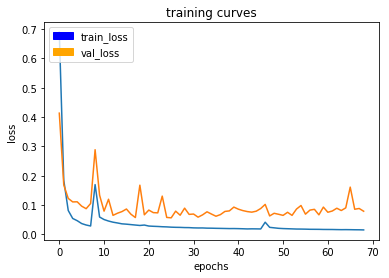

59/59 [==============================] - 113s - loss: 0.0155 - val_loss: 0.0791
Epoch 70/100
58/59 [============================>.] - ETA: 1s - loss: 0.0155

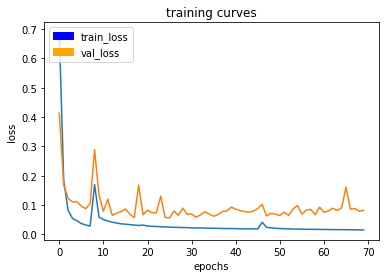

59/59 [==============================] - 113s - loss: 0.0155 - val_loss: 0.0822
Epoch 71/100
58/59 [============================>.] - ETA: 1s - loss: 0.0153

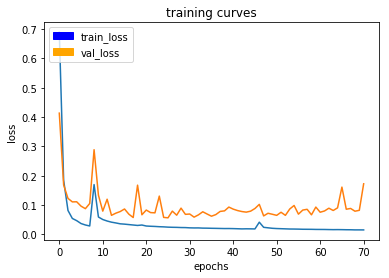

59/59 [==============================] - 113s - loss: 0.0154 - val_loss: 0.1725
Epoch 72/100
58/59 [============================>.] - ETA: 1s - loss: 0.0430

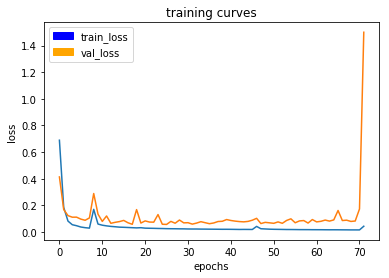

59/59 [==============================] - 113s - loss: 0.0427 - val_loss: 1.4996
Epoch 73/100
58/59 [============================>.] - ETA: 1s - loss: 0.0235

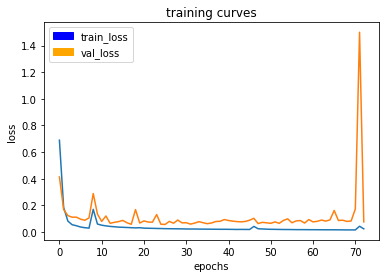

59/59 [==============================] - 113s - loss: 0.0234 - val_loss: 0.0754
Epoch 74/100
58/59 [============================>.] - ETA: 1s - loss: 0.0208

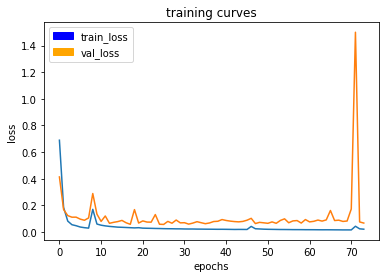

59/59 [==============================] - 113s - loss: 0.0207 - val_loss: 0.0668
Epoch 75/100
58/59 [============================>.] - ETA: 1s - loss: 0.0194

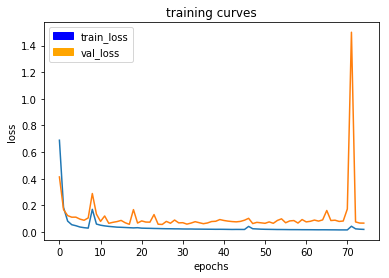

59/59 [==============================] - 114s - loss: 0.0194 - val_loss: 0.0664
Epoch 76/100
58/59 [============================>.] - ETA: 1s - loss: 0.0186

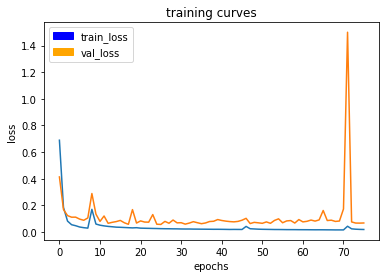

59/59 [==============================] - 112s - loss: 0.0186 - val_loss: 0.0675
Epoch 77/100
58/59 [============================>.] - ETA: 1s - loss: 0.0179

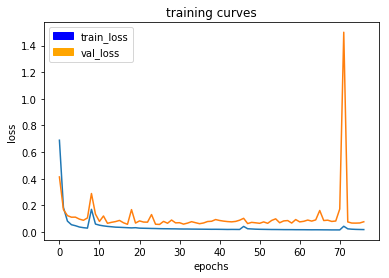

59/59 [==============================] - 113s - loss: 0.0180 - val_loss: 0.0766
Epoch 78/100
58/59 [============================>.] - ETA: 1s - loss: 0.0176

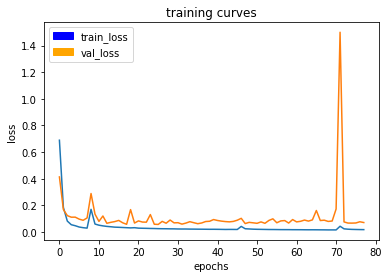

59/59 [==============================] - 113s - loss: 0.0176 - val_loss: 0.0708
Epoch 79/100
58/59 [============================>.] - ETA: 1s - loss: 0.0169

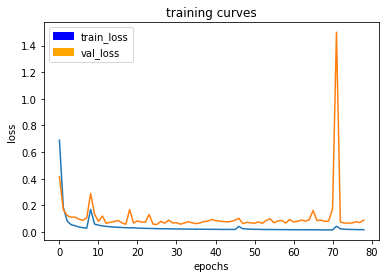

59/59 [==============================] - 113s - loss: 0.0169 - val_loss: 0.0892
Epoch 80/100
58/59 [============================>.] - ETA: 1s - loss: 0.0166

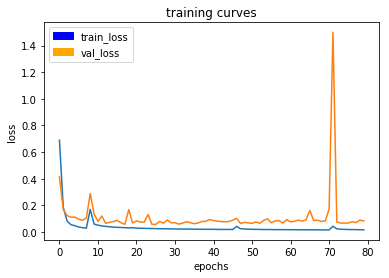

59/59 [==============================] - 112s - loss: 0.0166 - val_loss: 0.0822
Epoch 81/100
58/59 [============================>.] - ETA: 1s - loss: 0.0162

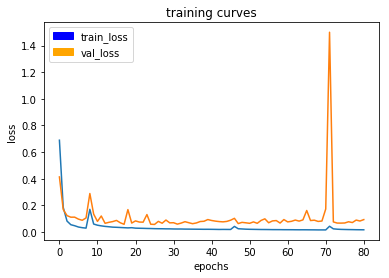

59/59 [==============================] - 112s - loss: 0.0163 - val_loss: 0.0929
Epoch 82/100
58/59 [============================>.] - ETA: 1s - loss: 0.0162

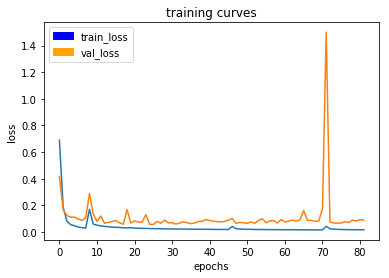

59/59 [==============================] - 113s - loss: 0.0162 - val_loss: 0.0889
Epoch 83/100
58/59 [============================>.] - ETA: 1s - loss: 0.0158

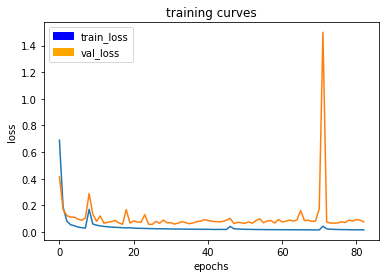

59/59 [==============================] - 113s - loss: 0.0158 - val_loss: 0.0762
Epoch 84/100
58/59 [============================>.] - ETA: 1s - loss: 0.0155

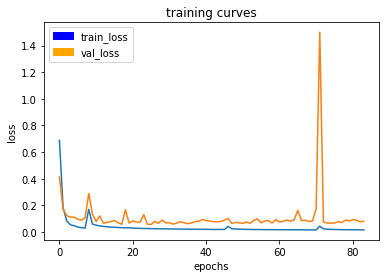

59/59 [==============================] - 112s - loss: 0.0155 - val_loss: 0.0807
Epoch 85/100
58/59 [============================>.] - ETA: 1s - loss: 0.0155

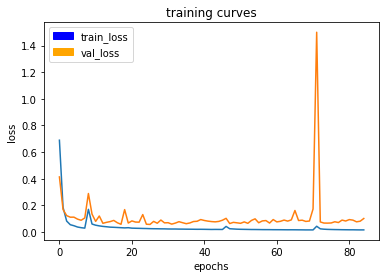

59/59 [==============================] - 112s - loss: 0.0155 - val_loss: 0.1011
Epoch 86/100
58/59 [============================>.] - ETA: 1s - loss: 0.0155

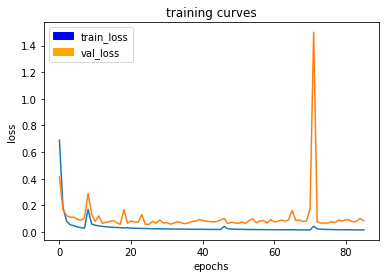

59/59 [==============================] - 112s - loss: 0.0154 - val_loss: 0.0847
Epoch 87/100
58/59 [============================>.] - ETA: 1s - loss: 0.0150

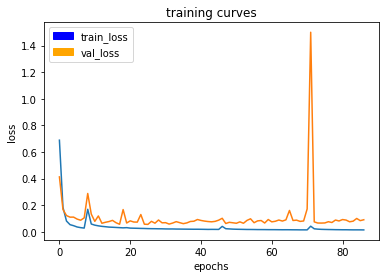

59/59 [==============================] - 112s - loss: 0.0150 - val_loss: 0.0914
Epoch 88/100
58/59 [============================>.] - ETA: 1s - loss: 0.0147

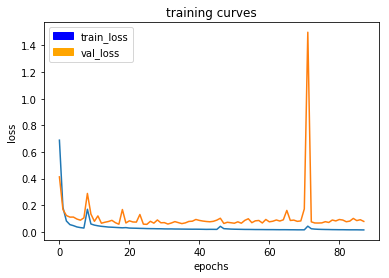

59/59 [==============================] - 112s - loss: 0.0147 - val_loss: 0.0786
Epoch 89/100
58/59 [============================>.] - ETA: 1s - loss: 0.0145

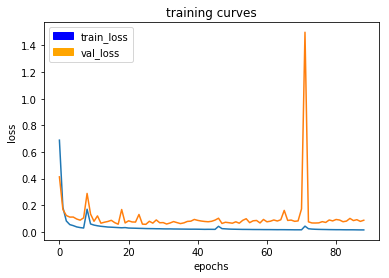

59/59 [==============================] - 112s - loss: 0.0146 - val_loss: 0.0873
Epoch 90/100
58/59 [============================>.] - ETA: 1s - loss: 0.0149

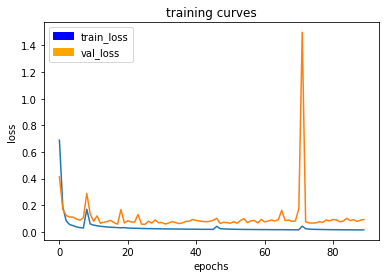

59/59 [==============================] - 112s - loss: 0.0150 - val_loss: 0.0928
Epoch 91/100
58/59 [============================>.] - ETA: 1s - loss: 0.0146

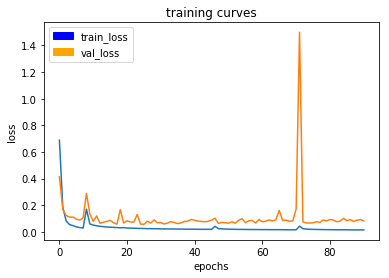

59/59 [==============================] - 112s - loss: 0.0146 - val_loss: 0.0816
Epoch 92/100
58/59 [============================>.] - ETA: 1s - loss: 0.0142

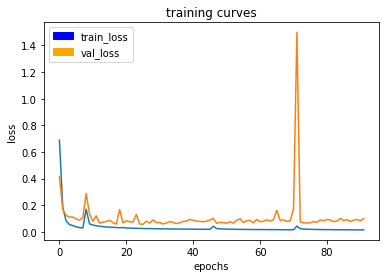

59/59 [==============================] - 113s - loss: 0.0142 - val_loss: 0.1004
Epoch 93/100
58/59 [============================>.] - ETA: 1s - loss: 0.0140

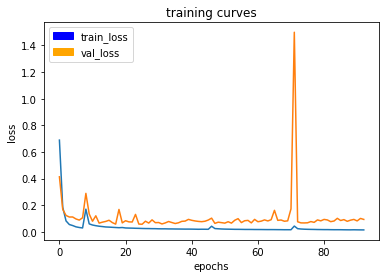

59/59 [==============================] - 112s - loss: 0.0140 - val_loss: 0.0928
Epoch 94/100
58/59 [============================>.] - ETA: 1s - loss: 0.0139

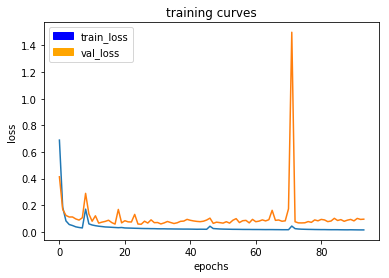

59/59 [==============================] - 113s - loss: 0.0139 - val_loss: 0.0945
Epoch 95/100
58/59 [============================>.] - ETA: 1s - loss: 0.0137

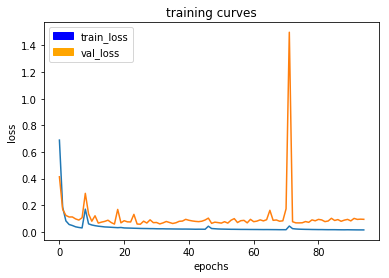

59/59 [==============================] - 112s - loss: 0.0137 - val_loss: 0.0934
Epoch 96/100
58/59 [============================>.] - ETA: 1s - loss: 0.0136

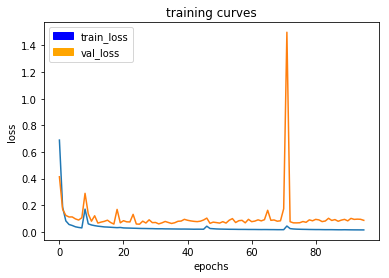

59/59 [==============================] - 113s - loss: 0.0136 - val_loss: 0.0855
Epoch 97/100
58/59 [============================>.] - ETA: 1s - loss: 0.0134

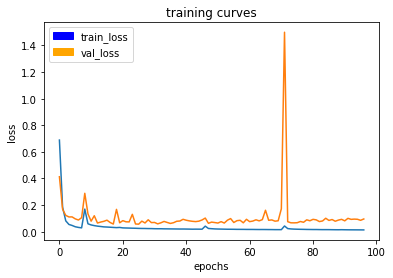

59/59 [==============================] - 113s - loss: 0.0134 - val_loss: 0.0956
Epoch 98/100
58/59 [============================>.] - ETA: 1s - loss: 0.0134

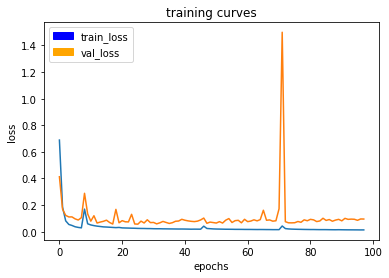

59/59 [==============================] - 113s - loss: 0.0134 - val_loss: 0.0951
Epoch 99/100
58/59 [============================>.] - ETA: 1s - loss: 0.0247

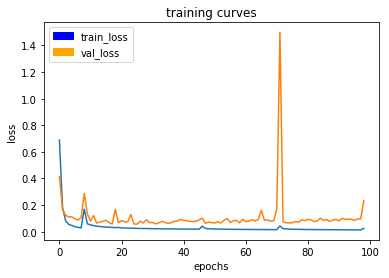

59/59 [==============================] - 113s - loss: 0.0246 - val_loss: 0.2345
Epoch 100/100
58/59 [============================>.] - ETA: 1s - loss: 0.0189

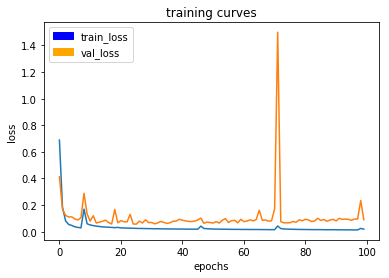

59/59 [==============================] - 112s - loss: 0.0189 - val_loss: 0.0907


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

#model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')
model.compile(optimizer=keras.optimizers.Nadam(), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [ ]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [11]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

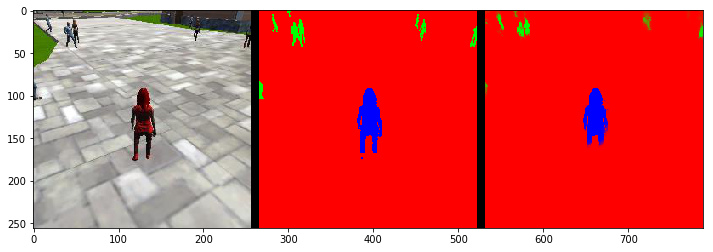

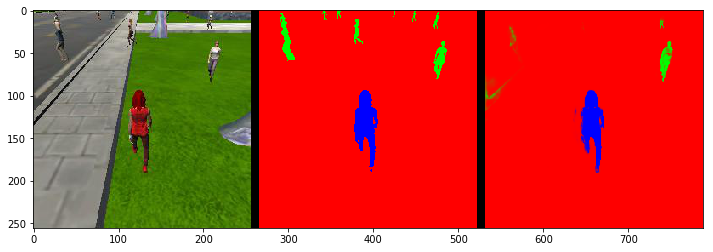

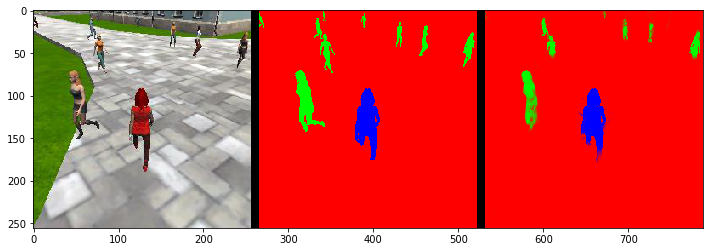

In [12]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

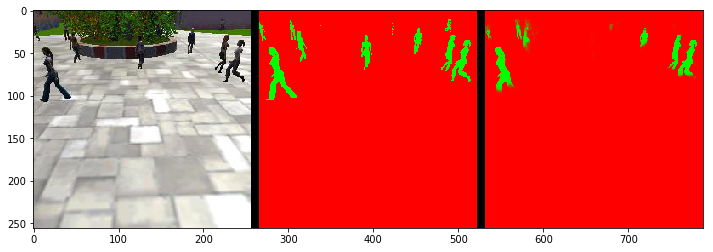

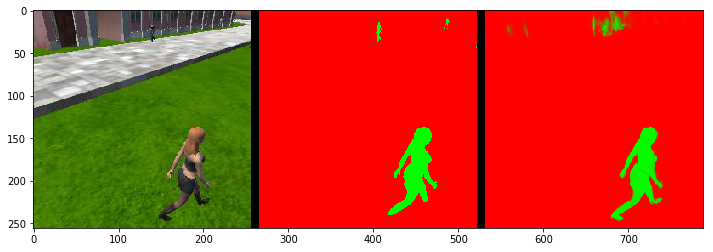

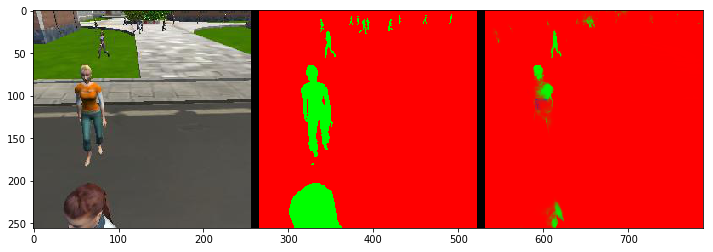

In [13]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

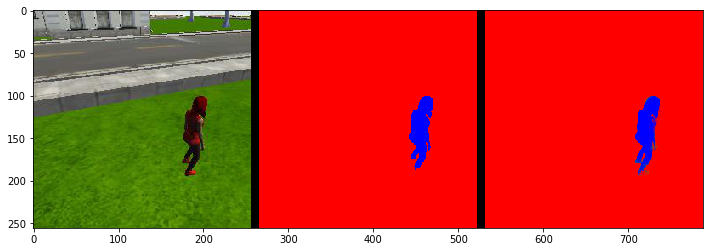

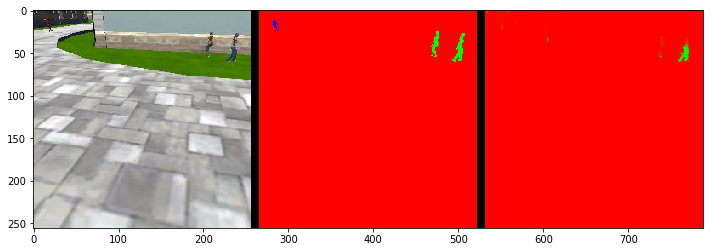

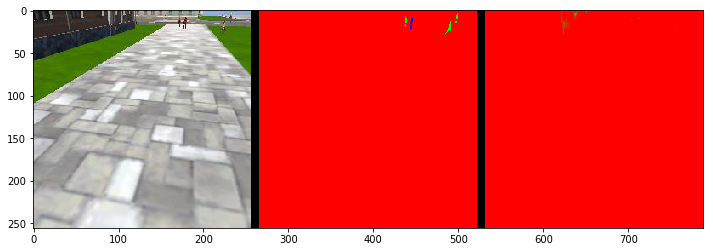

In [14]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [15]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9942889479584304
average intersection over union for other people is 0.2346893201979017
average intersection over union for the hero is 0.9126449450887907
number true positives: 539, number false positives: 0, number false negatives: 0


In [16]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9809438163092788
average intersection over union for other people is 0.6136876495897607
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 61, number false negatives: 0


In [17]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9952176525479581
average intersection over union for other people is 0.34625835195110016
average intersection over union for the hero is 0.25002314079280835
number true positives: 147, number false positives: 0, number false negatives: 165


In [18]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7521929824561403


In [19]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.581334042941


In [20]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.437275387563
